In [ ]:
'''
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
'''

In [1]:
'''
Convert files in test and training set folders into two CSV files,
with format: 
 text   |  label
review  |   0/1(0=negtive,1=positive)
'''

'\nConvert files in test and training set folders into two CSV files,\nwith format: \n text   |  label\nreview  |   0/1(0=negtive,1=positive)\n'

In [ ]:
#You only need to run one times, and you don't need to run again after that.
# or if you have the csv files ，you don't need to run it

In [ ]:
import os
import pandas as pd

def read_reviews(directory):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            if filename.endswith('.txt'):
                with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                    review = file.read()
                    reviews.append(review)
                    labels.append(1 if label == 'pos' else 0)
    return reviews, labels

def create_csv(reviews, labels, output_file):
    df = pd.DataFrame({'text': reviews, 'label': labels})
    df.to_csv(output_file, index=False)

# Define paths
train_dir = 'aclImdb/train'
test_dir = 'aclImdb/test'

# Read and convert training data
train_reviews, train_labels = read_reviews(train_dir)
create_csv(train_reviews, train_labels, 'train.csv')

# Read and convert test data
test_reviews, test_labels = read_reviews(test_dir)
create_csv(test_reviews, test_labels, 'test.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification,  get_linear_schedule_with_warmup
from tqdm import tqdm
import warnings
from torch.optim import AdamW
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

T:\Anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aa123\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aa123\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1]:
import torch
print(torch.__version__)

2.9.0+cu130


In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using divice：{device}")

using divice：cuda


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

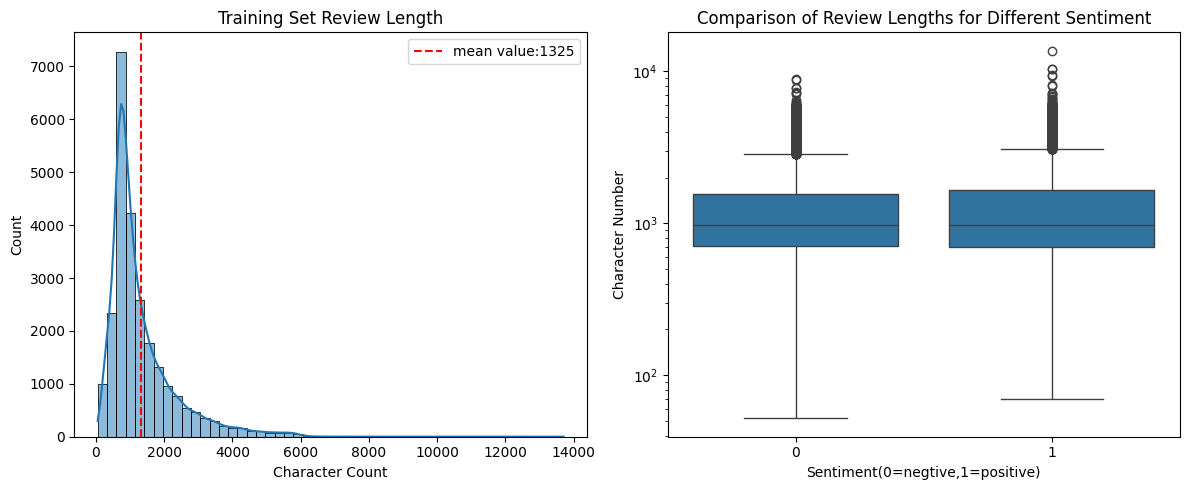

In [6]:
# Calculate comment length (in characters)
train_df['length'] = train_df['text'].apply(lambda x: len(x))
test_df['length'] = test_df['text'].apply(lambda x: len(x))

plt.figure(figsize=(12, 5))
# Training set length distribution
plt.subplot(1, 2, 1)
sns.histplot(train_df['length'], kde=True, bins=50)
plt.axvline(train_df['length'].mean(), color='r', linestyle='--', label=f"mean value:{train_df['length'].mean():.0f}")
plt.title('Training Set Review Length')
plt.xlabel('Character Count')
plt.legend()

# Length comparison for different sentiments
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='length', data=train_df)
#Logarithmic scale to reduce the impact of extreme values
plt.yscale('log') 
plt.title('Comparison of Review Lengths for Different Sentiment')
plt.xlabel('Sentiment(0=negtive,1=positive)')
plt.ylabel('Character Number')

plt.tight_layout()
plt.show()

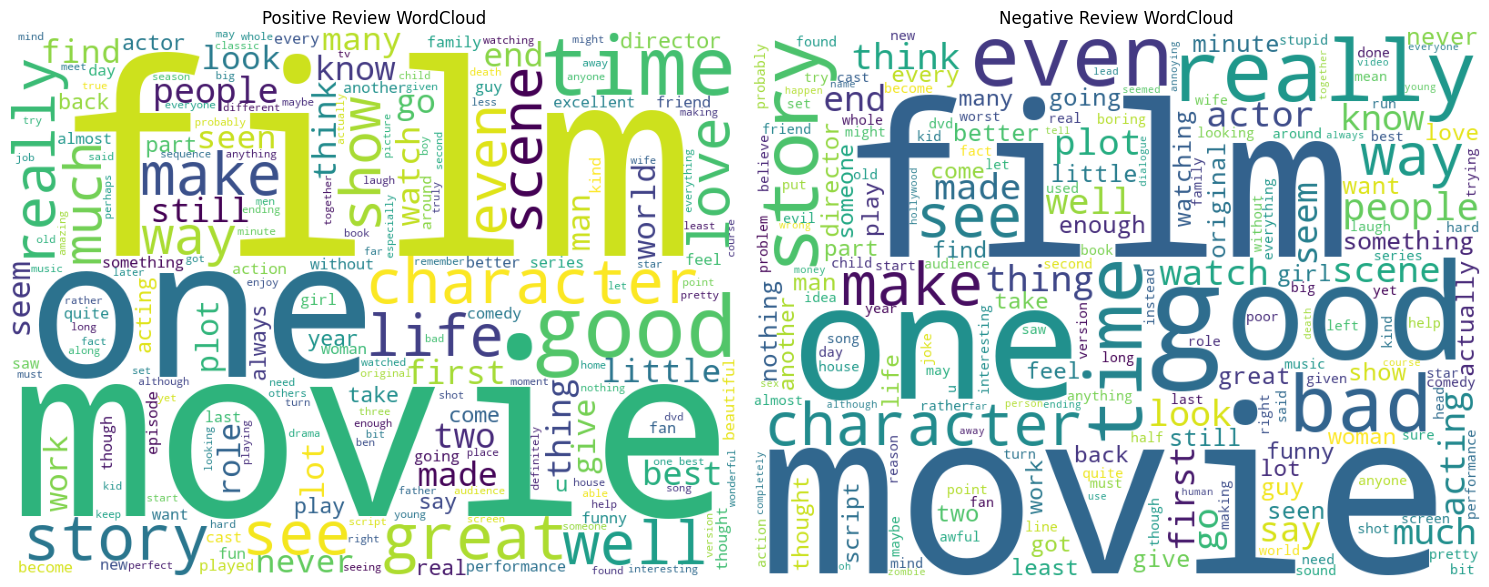

In [7]:
# Simple Text Preprocessing (for Keyword Analysis)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def simple_preprocess(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep only letters
    text = text.lower()  # Convert to lowercase
    words = text.split() # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Preprocess a sample (full processing takes longer)
sample_size = 1000
train_sample = train_df.sample(sample_size, random_state=42)
train_sample['clean_text'] = train_sample['text'].apply(simple_preprocess)

# Extract keywords for positive and negative sentiment
positive_text = ' '.join(train_sample[train_sample['label']==1]['clean_text'])
negative_text = ' '.join(train_sample[train_sample['label']==0]['clean_text'])

# Generate word clouds
from wordcloud import WordCloud
plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=600, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos)
plt.title('Positive Review WordCloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=600, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg)
plt.title('Negative Review WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
#simply cleaning text
def clean_text(text):
    #Lightweight text cleaning, retaining information needed by Transformer
    text = re.sub(r'<.*?>', '', text)  #  Remove HTML tags 
    text = re.sub(r'http\S+', '', text)  #  Remove URL
    text = re.sub(r'@\w+', '', text)  # Remove @ mentions text
    text = re.sub(r'\s+', ' ', text).strip()  # Merge extra spaces
    return text

# clean the training data and test data
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)
#print(train_df)

In [10]:
# Load the tokenizer for BERT base model
model_name = 'bert-base-uncased'  # name model as"bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# test the tokenizer
sample_text = train_df['clean_text'].iloc[100]
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Original text：{sample_text[:100]}...")
print(f"Tokenization output：{tokens[:10]}...")
print(f"token ID：{token_ids[:10]}...")

Original text：I was prepared for a turgid talky soap opera cum travelogue, but was pleased to find a fast-paced sc...
Tokenization output：['i', 'was', 'prepared', 'for', 'a', 'tu', '##rg', '##id', 'talk', '##y']...
token ID：[1045, 2001, 4810, 2005, 1037, 10722, 10623, 3593, 2831, 2100]...


In [13]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length  # The maximum length of the BERT base model is 512.

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # 编码文本
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=self.max_length,
            padding='max_length',  # Pad to max_length
            truncation=True,  # Truncate long texts
            return_attention_mask=True,
            return_tensors='pt'  # return to PyTorch
        )
        
        # Convert to a single-dimension tensor (remove the batch dimension)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split the validation set (take 10% from the training set)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['clean_text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=train_df['label'].tolist()  # Maintain consistent emotional distribution
)

# create dataset
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset = IMDBDataset(test_df['clean_text'].tolist(), test_df['label'].tolist(), tokenizer)

# Create a data loader (supporting batch processing and shuffling)
batch_size = 16  # Adjust batch size according to GPU memory(we use 32 in my pc and 16 in lab pc)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Load the BERT model with classification header
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification (positive/negative)
    output_attentions=False,  # Do not return attention weights
    output_hidden_states=False  # Do not return hidden states
)

# Move the model to GPU 
model = model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Optimizer parameters
learning_rate = 2e-5  # Recommended learning rate for BERT
epsilon = 1e-8  # AdamW's numerical stability parameter

# Define Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    eps=epsilon
)

# Learning Rate Scheduler 
epochs = 5 # we train a lot of times and the 5 is the best to set ,cause everytime accuracy reached maximum in the third epoch
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  
    num_training_steps=total_steps
)

In [16]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()  # Training Mode
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="训练"):
        # Extract batch data and move it to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Reset the gradient 
        model.zero_grad()
        
        # Forward Propagation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        # Calculate losses
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backpropagation and Parameter Update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
        optimizer.step()
        scheduler.step()
    
    # average loss 
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()  # Evaluation Mode
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(dataloader, desc="评估"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            # Total losses
            total_loss += outputs.loss.item()
            
            # Get the predicted output
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            
            # true label
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy, predictions, true_labels

# train the model
best_val_accuracy = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 10)
    
    # train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    print(f"训练损失：{train_loss:.4f}")
    
    # validation
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"验证损失：{val_loss:.4f}，验证准确率：{val_acc:.4f}")
    
    # save the best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_bert_model.bin')
        print("保存最佳模型")


Epoch 1/5
----------


训练: 100%|██████████| 1407/1407 [13:44<00:00,  1.71it/s]


训练损失：0.2610


评估: 100%|██████████| 157/157 [00:39<00:00,  3.94it/s]


验证损失：0.2237，验证准确率：0.9220
保存最佳模型

Epoch 2/5
----------


训练: 100%|██████████| 1407/1407 [13:44<00:00,  1.71it/s]


训练损失：0.1401


评估: 100%|██████████| 157/157 [00:47<00:00,  3.28it/s]


验证损失：0.2511，验证准确率：0.9280
保存最佳模型

Epoch 3/5
----------


训练: 100%|██████████| 1407/1407 [13:45<00:00,  1.70it/s]


训练损失：0.0764


评估: 100%|██████████| 157/157 [00:50<00:00,  3.13it/s]


验证损失：0.2623，验证准确率：0.9396
保存最佳模型

Epoch 4/5
----------


训练: 100%|██████████| 1407/1407 [13:45<00:00,  1.70it/s]


训练损失：0.0414


评估: 100%|██████████| 157/157 [00:49<00:00,  3.20it/s]


验证损失：0.3671，验证准确率：0.9356

Epoch 5/5
----------


训练: 100%|██████████| 1407/1407 [13:45<00:00,  1.70it/s]


训练损失：0.0219


评估: 100%|██████████| 157/157 [00:50<00:00,  3.14it/s]

验证损失：0.3808，验证准确率：0.9376


In [17]:
print(train_losses)
print(val_losses)
print(val_accuracies)

[0.2609972426602941, 0.14009017878269622, 0.0764021300876218, 0.04140699515268127, 0.021914847721520303]
[0.2237349592659409, 0.2511375191099467, 0.26233697711389253, 0.3670646670433117, 0.3807615690368189]
[0.922, 0.928, 0.9396, 0.9356, 0.9376]


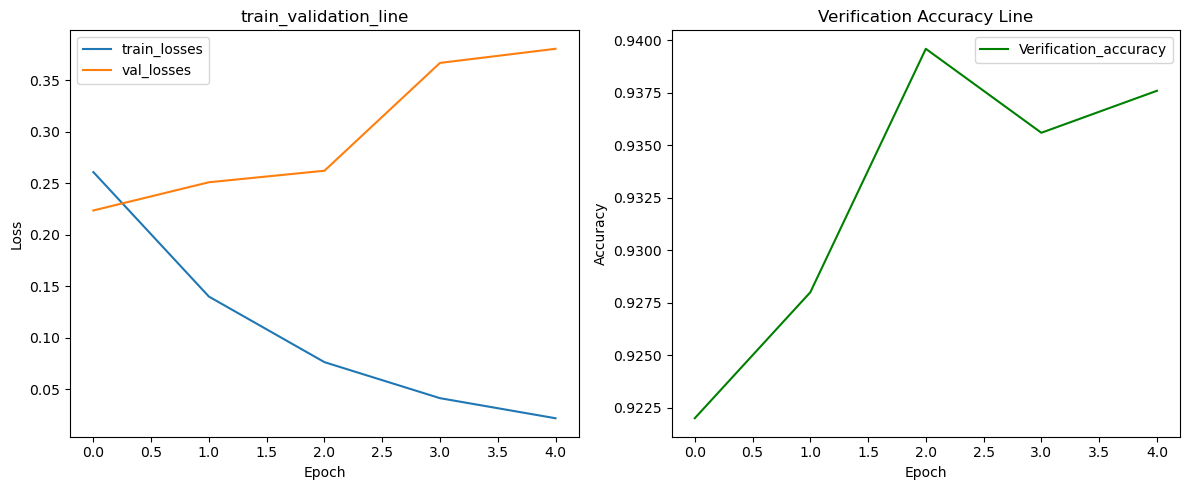

In [18]:
#plot the train_validation_line
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train_losses')
plt.plot(val_losses, label='val_losses')
plt.title('train_validation_line')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plot the Verification_accuracy_line
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Verification_accuracy', color='g')
plt.title('Verification Accuracy Line')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Load optimal model weights
model.load_state_dict(torch.load('best_bert_model.bin'))

# Evaluate on the test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"\n测试集结果：")
print(f"损失：{test_loss:.4f}，准确率：{test_acc:.4f}")

# Classification Report (Precision, Recall, F1-Score)
print("\n分类报告：")
print(classification_report(test_labels, test_preds, target_names=['negative', 'positive']))

评估: 100%|██████████| 1563/1563 [06:11<00:00,  4.21it/s]


测试集结果：
损失：0.2503，准确率：0.9371

分类报告：
              precision    recall  f1-score   support

    negative       0.95      0.92      0.94     12500
    positive       0.92      0.95      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000



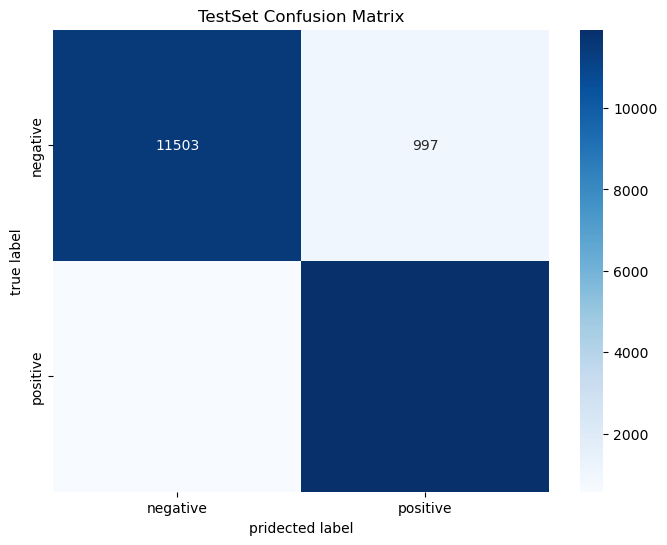

In [21]:
# Plot the Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'positive'], 
            yticklabels=['negative', 'positive'])
plt.xlabel('pridected label')
plt.ylabel('true label')
plt.title('TestSet Confusion Matrix')
plt.show()

In [22]:
# Samples with erroneous predictions
test_df['pred'] = test_preds
errors = test_df[test_df['label'] != test_df['pred']]

# Print some error samples
print("\n错误预测案例：")
for i in range(3):
    print(f"\n样本 {i+1}：")
    print(f"真实标签：{'正面' if errors['label'].iloc[i] == 1 else '负面'}")
    print(f"预测标签：{'正面' if errors['pred'].iloc[i] == 1 else '负面'}")
    print(f"评论内容：{errors['clean_text'].iloc[i][:300]}...")


错误预测案例：

样本 1：
真实标签：正面
预测标签：负面
评论内容：[CONTAINS SPOILERS!!!] Garfield and his owner Jon Arbuckle were in a rut. They basically had no life at all. All they did was lay around and count the ceiling tiles. Jon even organized his sock drawer according to color and fabric. He needed a life. So he consults a book on the subject that tells hi...

样本 2：
真实标签：正面
预测标签：负面
评论内容：So, Madonna isn't Meryl Streep. Still, this is one of her first films and a comedy at that. Give her a break! Sure, the movie is mediocre at best and pales in comparison to its earlier counterpart w/ Katherine Hepburn, Bringing Up Baby. For what it is, though(a piece of fluff), it's quite a bit of f...

样本 3：
真实标签：正面
预测标签：负面
评论内容：What can I say about this film that won't give you any preconceived notions when you see it? Very little. The plot has to do with the return from hospital of a teenage girl after she broke down. What follows after that is the movie. It is one of the creepiest most mind blowing films of the past sev

In [9]:
#Interactive detection method
import torch
import re
from transformers import BertTokenizer, BertForSequenceClassification

# ----------------------------
# Config(must be consistent with training)
# ----------------------------
MODEL_NAME = 'bert-base-uncased'
MODEL_PATH = 'best_bert_model.bin'
MAX_LENGTH = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Text preprocessing function (consistent with training)
# ----------------------------
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  #  Remove HTML tags 
    text = re.sub(r'http\S+', '', text)  #  Remove URL
    text = re.sub(r'@\w+', '', text)  # Remove @ mentions text
    text = re.sub(r'\s+', ' ', text).strip()  # Merge extra spaces
    return text


# ----------------------------
# load the model and tokenizer
# ----------------------------
print("正在加载模型和tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print(f"模型已加载到设备：{DEVICE}")

# ----------------------------
# Inference Function
# ----------------------------
def predict_sentiment(text: str) -> str:
    cleaned = clean_text(text)
    inputs = tokenizer(
        cleaned,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(DEVICE)
    attention_mask = inputs['attention_mask'].to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    return "正面" if prediction == 1 else "负面"

# ----------------------------
# Interactive Loop 
# ----------------------------
print("\n 欢迎使用 IMDB 情感分析系统！")
print("请输入一段英文电影评论，模型将判断其情感倾向。")
print("输入 'quit' 退出。\n")

while True:
    user_input = input("请输入评论: ").strip()
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("再见！")
        break
    if not user_input:
        print("输入不能为空，请重试。")
        continue

    try:
        result = predict_sentiment(user_input)
        print(f"预测结果：{result}\n")
    except Exception as e:
        print(f"推理出错：{e}\n")

正在加载模型和tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型已加载到设备：cuda

 欢迎使用 IMDB 情感分析系统！
请输入一段英文电影评论，模型将判断其情感倾向。
输入 'quit' 退出。



请输入评论:  Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even 


预测结果：负面



请输入评论:  This film is more than just a story about prison life — it’s a profound meditation on hope, resilience, and the human spirit


预测结果：正面



请输入评论:  As a fan of the original animated series, this adaptation broke my heart. The casting choices erased the rich cultural inspirations, the dialogue is wooden, and the pacing is painfully slow


预测结果：负面



请输入评论:  quit


再见！
